In [2]:
import time
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt

import jumpy
import jumpy.numpy as jp
import jax
import jax.numpy as jnp
import jax.random as rnd
from jax.tree_util import tree_map

import rex.utils as utils
import rex.open_colors as oc
from rex.wrappers import GymWrapper, AutoResetWrapper, VecGymWrapper
from rex.proto import log_pb2
from rex.node import Node
from rex.agent import Agent
from rex.constants import LATEST, BUFFER, SILENT, DEBUG, INFO, WARN, SYNC, ASYNC, REAL_TIME, FAST_AS_POSSIBLE, FREQUENCY, PHASE, SIMULATED, WALL_CLOCK, VECTORIZED
from rex.distributions import Gaussian, GMM
from rex.base import GraphState, StepState
from scripts.dummy import DummyNode, DummyAgent

utils.set_log_level(WARN)

In [3]:
import experiments as exp
import stable_baselines3 as sb3
import envs.double_pendulum as dpend

# Environment
ENV = "double_pendulum"
DIST_FILE = f"21eps_pretrained_sbx_sac_gmms_2comps.pkl"
JITTER = BUFFER
SCHEDULING = PHASE
MAX_STEPS = 5*80
WIN_ACTION = 2
WIN_OBS = 3
BLOCKING = True
ADVANCE = False
ENV_FN = dpend.ode.build_double_pendulum
ENV_CLS = dpend.env.DoublePendulumEnv
CLOCK = SIMULATED
RTF = REAL_TIME
RATES = dict(world=150, agent=80, actuator=80, sensor=80, render=20)
DELAY_FN = lambda d: d.high*0.75
USE_DELAYS = True   # todo: TOGGLE WITH/WITHOUT DELAYS HERE

# Load models
MODEL_CLS = sb3.SAC  # sbx.SAC
MODEL_MODULE = dpend.models
MODEL_PRELOAD = "sb_sac_model"

# Training
SEED = 0
NUM_ENVS = 10
SAVE_FREQ = 40_000
NSTEPS = 200_000
NUM_EVAL_PRE = 1
NUM_EVAL_POST = 20
HYPERPARAMS = {"learning_rate": 0.01}
CONTINUE = True

# Record settings
RECORD_SETTINGS = {"agent": dict(node=True, outputs=True, rngs=True, states=True, params=True, step_states=True),
                   "world": dict(node=True, outputs=True, rngs=True, states=True, params=True, step_states=True),
                   "actuator": dict(node=True, outputs=True, rngs=True, states=True, params=True, step_states=True),
                   "sensor": dict(node=True, outputs=True, rngs=True, states=True, params=True, step_states=True),
                   "render": dict(node=True, outputs=False, rngs=True, states=True, params=True, step_states=True)}

In [4]:
# Load distributions
delays_sim = exp.load_distributions(DIST_FILE)

# Prepare environment
env = exp.make_env(delays_sim, DELAY_FN, RATES, blocking=BLOCKING, advance=ADVANCE, win_action=WIN_ACTION, win_obs=WIN_OBS,
                   scheduling=SCHEDULING, jitter=JITTER,
                   env_fn=ENV_FN, env_cls=ENV_CLS, name=ENV, eval_env=True, clock=CLOCK, real_time_factor=RTF,
                   max_steps=MAX_STEPS, use_delays=USE_DELAYS)
gym_env = GymWrapper(env)

# Load model
model = exp.load_model(MODEL_PRELOAD, MODEL_CLS, env=gym_env, seed=SEED, module=MODEL_MODULE)

# Make policy
policy = exp.make_policy(model)

# Evaluate model
record_pre = exp.eval_env(gym_env, policy, n_eval_episodes=NUM_EVAL_PRE, verbose=True, seed=SEED, record_settings=RECORD_SETTINGS)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
double_pendulum_ode_eval_buffer_phase_awin2_owin3_blocking_noadvance | steps=400 | fps= 99.7560 | reward=80.62812382133953
double_pendulum_ode_eval_buffer_phase_awin2_owin3_blocking_noadvance | mean reward=80.63 +/- 0.00


In [5]:
# Trace & compile environment
cenv = exp.make_compiled_env(env, record_pre.episode[-1], max_steps=MAX_STEPS, eval_env=False, graph_type=VECTORIZED    )

Trace | name='agent' | tick=400 | deps (seq): 3942/4800 | step (seq): 1950/2055 | steps (batch): 2654/2055 | steps (vec): 2801/2055 (max_consecutive=2)


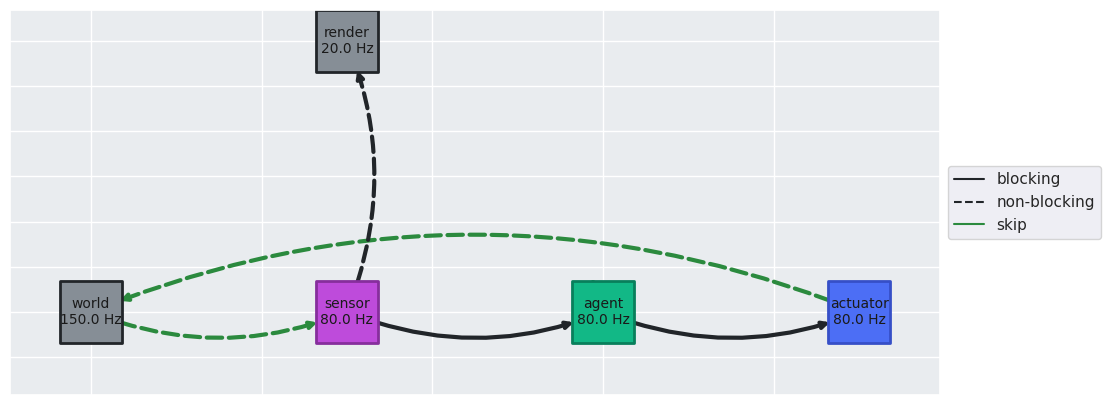

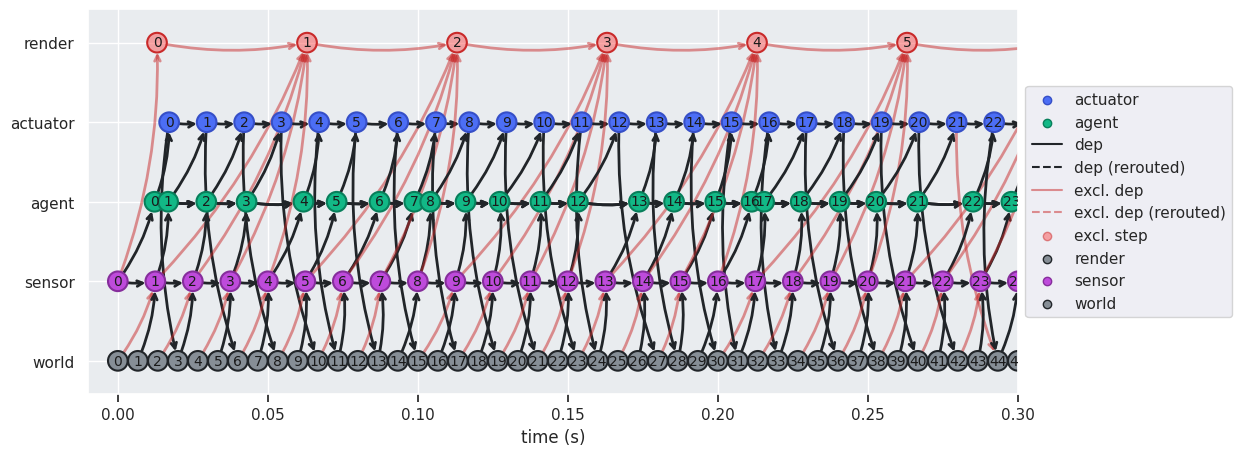

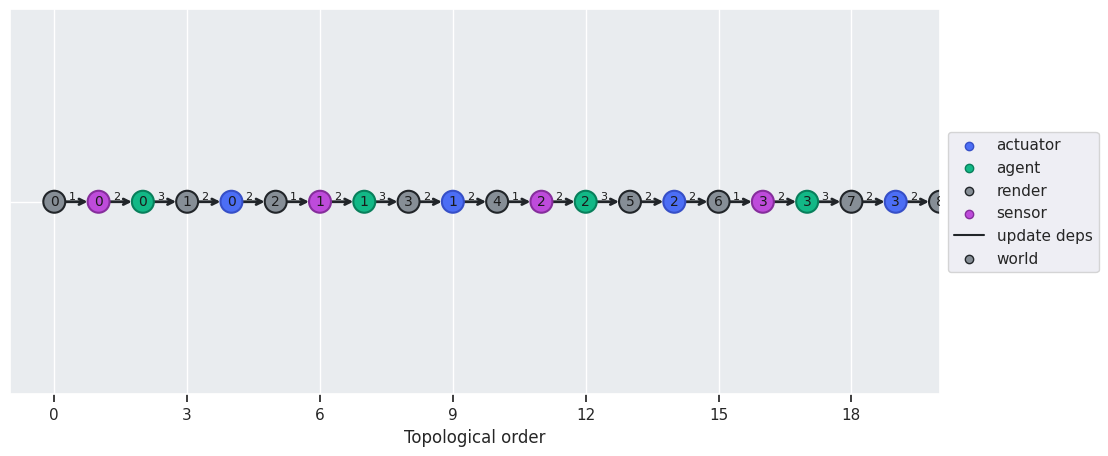

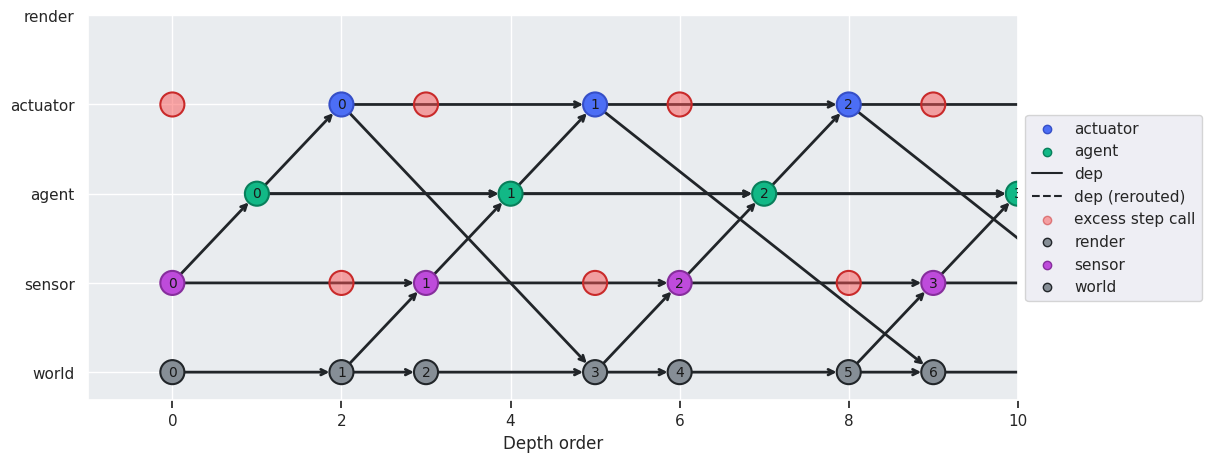

In [6]:
# Plot
fig_gr, _ = exp.show_graph(cenv.graph.trace.episode)
fig_cg, _ = exp.show_computation_graph(cenv.graph.trace,"computation", xmax=0.35)
fig_ct, _ = exp.show_computation_graph(cenv.graph.trace,"topological", xmax=0.35)
fig_cd, _ = exp.show_computation_graph(cenv.graph.trace,"depth", xmax=0.35)
# fig_com, _ = exp.show_communication(record_pre.episode[-1])
# fig_grp, _ = exp.show_grouped(record_pre.episode[-1].node[-1], "state")

In [7]:
import time
import rex.jumpy as rjp
from rex.utils import timer

rw = exp.RolloutWrapper(cenv)

nenvs = 7000
seed = jumpy.random.PRNGKey(0)
rng = jumpy.random.split(seed, num=nenvs)
for i in range(5):
    seed = jumpy.random.PRNGKey(i)
    rng = jumpy.random.split(seed, num=nenvs)
    timer = utils.timer(f"{i=}", log_level=0)
    with timer:
        res = rw.batch_rollout(rng)
    fps = env.max_steps * nenvs / timer.duration
    print(f"[{timer.name}] time={timer.duration} sec | fps={fps:.0f} steps/sec")

[i=0] time=8.904746055603027 sec | fps=314439 steps/sec
[i=1] time=1.820561170578003 sec | fps=1537987 steps/sec
[i=2] time=1.822359561920166 sec | fps=1536470 steps/sec
[i=3] time=1.7953739166259766 sec | fps=1559564 steps/sec
[i=4] time=1.8328773975372314 sec | fps=1527653 steps/sec
